In [1]:
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)
import xarray as xr

import h5py
import cartopy.crs as ccrs
    
from mydedalustools import *    

%load_ext autoreload
%autoreload 2

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1


/global/common/software/m3310/conda/dedalus3/lib/python3.11/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
# Simulation units
meter = 1 / 6.37122e6
hour = 1
second = hour / 3600
day = hour*24
Kelvin = 1

# Earth parameters
R0 = 6.4e6*meter
Omega = 2*np.pi/86400 / second

SNAPSHOTS_DIR = "/pscratch/sd/q/qnicolas/stationarywave_snapshots/"

# Shallow water stationary Rossby wave

To obtain the solutions, run "mpiexec -n 8 python stationarywave_SW.py" with the lhs option turned to True, then to False

In [3]:
snapshot_id = 'stationarywave_SW_rhs'
swrhs = open_h5(snapshot_id,'s1',SNAPSHOTS_DIR=SNAPSHOTS_DIR)
snapshot_id = 'stationarywave_SW_lhs'
swlhs = open_h5(snapshot_id,'s1',SNAPSHOTS_DIR=SNAPSHOTS_DIR)

## Basic-state wind and geopotential, topography

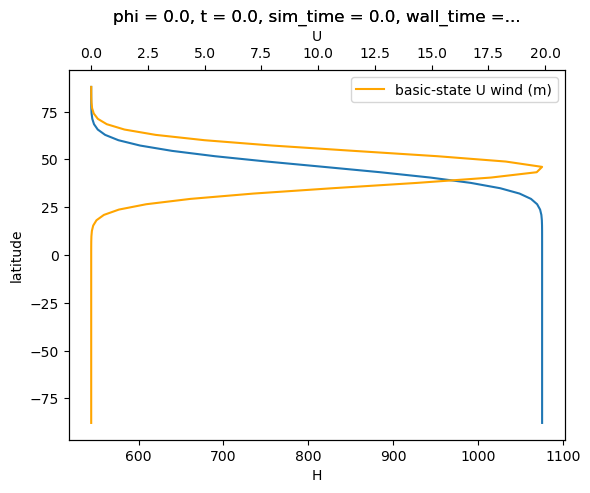

In [4]:
(swrhs.H[0,0]/meter).plot(y='latitude',label='basic-state height field (m)')
plt.twiny()
(swrhs.U[0,0,0]/(meter/second)).plot(y='latitude',color='orange',label='basic-state U wind (m)')
plt.legend()

Text(0.5, 1.0, 'Topography (m)')

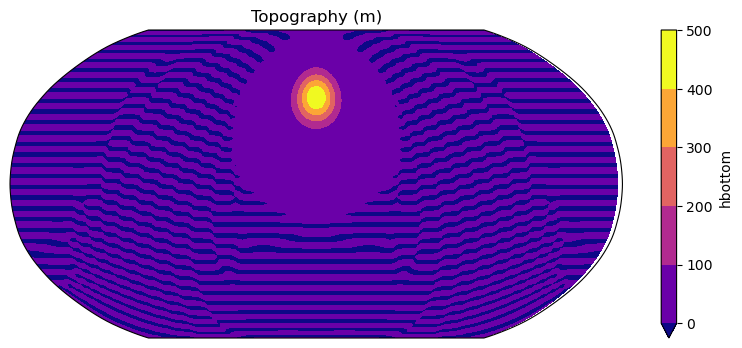

In [5]:
# Perturbation vorticity in rhs run
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})
(swrhs.hbottom[0]/meter).transpose().plot.contourf(ax=ax,levels=np.arange(0,501,100.),transform=ccrs.PlateCarree(),cmap=plt.cm.plasma)
plt.title('Topography (m)')

## time evolution

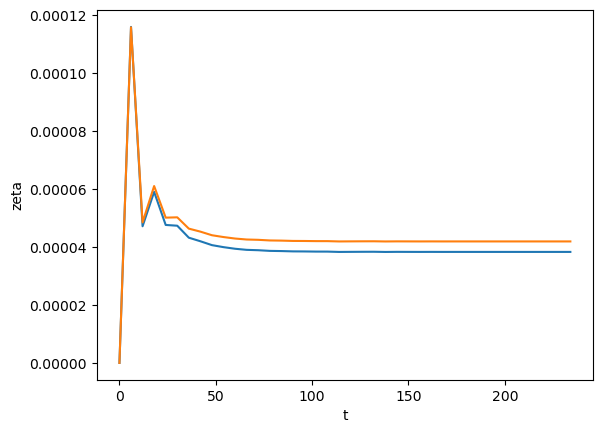

In [6]:
# Evolution of the mean enstrophy
(swrhs.zeta**2).mean(('latitude','longitude')).plot()
(swlhs.zeta**2).mean(('latitude','longitude')).plot()

## Solution

In [7]:
swrhs_mean = swrhs.sel(t=slice(150,500)).mean('t').transpose('','latitude','longitude')
swlhs_mean = swlhs.sel(t=slice(150,500)).mean('t').transpose('','latitude','longitude')

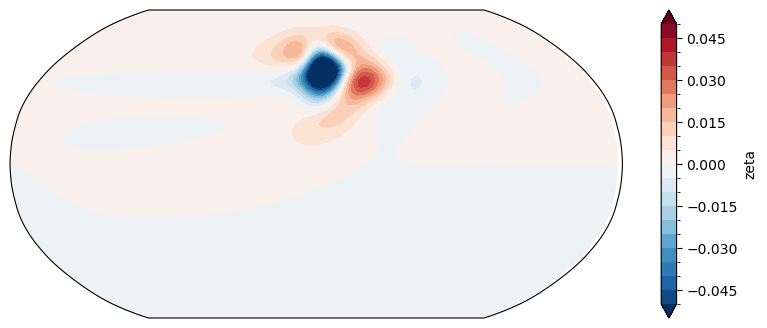

In [8]:
# Perturbation vorticity in rhs run
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})
swrhs_mean.zeta.plot.contourf(ax=ax,levels=np.linspace(-0.05,0.05,21),extend='both',transform=ccrs.PlateCarree())

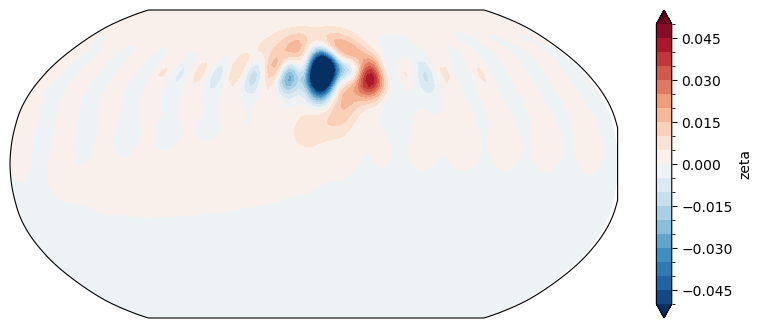

In [9]:
# Perturbation vorticity in lhs run
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})
swlhs_mean.zeta.plot.contourf(ax=ax,levels=np.linspace(-0.05,0.05,21),extend='both',transform=ccrs.PlateCarree())

Text(0.5, 1.0, 'total geopotential height, wind, and topography (white contour)')

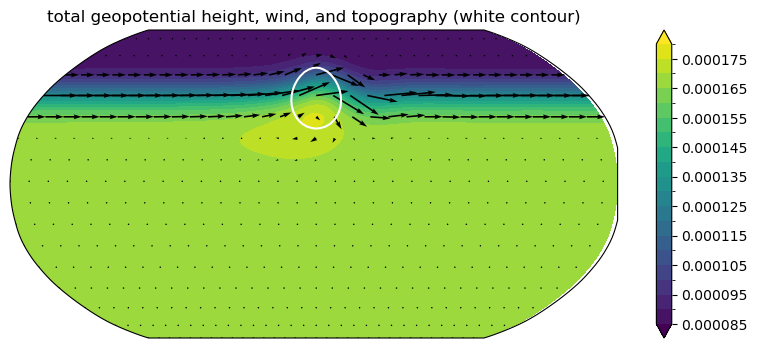

In [11]:
# Perturbation vorticity in first run
Sim = swrhs_mean
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})
(Sim.H[:,0]+Sim.hbottom+Sim.h).plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree())
Sim.hbottom.plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[1e2 * meter ],colors='w')

u= (Sim.U[0,:,0]+Sim.u[0])
v=-(Sim.U[1,:,0]+Sim.u[1])
n=4; m=n
X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
Q = ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m],color="k",transform=ccrs.PlateCarree(),scale=0.2)

plt.title('total geopotential height, wind, and topography (white contour)')

Text(0.5, 1.0, 'Perturbation geopotential height, wind, and topography (white contour)')

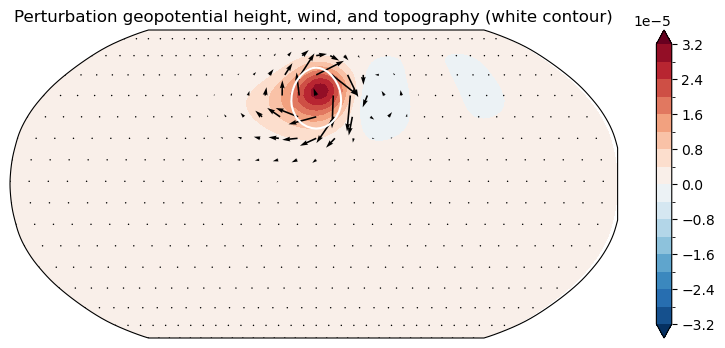

In [12]:
# Perturbation vorticity in first run
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson()})
(Sim.hbottom+Sim.h).plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree())
Sim.hbottom.plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[1e2 * meter ],colors='w')

u= (Sim.u[0])
v=-(Sim.u[1])
n=4; m=n
X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
Q = ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m],color="k",transform=ccrs.PlateCarree(),scale=0.1)

plt.title('Perturbation geopotential height, wind, and topography (white contour)')